# Proyecto final. Telecomunicaciones: Identificación de operadores ineficaces.

El servicio de telefonía virtual CallMeMaybe está desarrollando una nueva función que brindará a los supervisores y las supervisores información sobre los operadores menos eficaces. Esto, con el fin de implementar nuevas estrategias para aumentar la productividad de los operadores y a su vez la satisfacción en los clientes.

## Objetivo General: Identificar operadores ineficaces
Para detectar los operadores ineficaces se tomaron lo siguientes criterios:

- Un tiempo de espera prolongado para las llamadas entrantes. 
- Si tiene una gran cantidad de llamadas entrantes perdidas (internas y externas).
- Un número reducido de llamadas salientes.

## Descripción de los datos: 

Los datasets contienen información sobre el uso del servicio de telefonía virtual CallMeMaybe. Sus clientes son organizaciones que necesitan distribuir gran cantidad de llamadas entrantes entre varios operadores, o realizar llamadas salientes a través de sus operadores. Los operadores también pueden realizar llamadas internas para comunicarse entre ellos. Estas llamadas se realizan a través de la red de CallMeMaybe.

El dataset comprimido `telecom_dataset_us.csv` contiene las siguientes columnas:

- `user_id`: ID de la cuenta de cliente
- `date`: fecha en la que se recuperaron las estadísticas
- `direction`: "dirección" de llamada (`out` para saliente, `in` para entrante)
- `internal`: si la llamada fue interna (entre los operadores de un cliente o clienta)
- `operator_id`: identificador del operador
- `is_missed_call`: si fue una llamada perdida
- `calls_count`: número de llamadas
- `call_duration`: duración de la llamada (sin incluir el tiempo de espera)
- `total_call_duration`: duración de la llamada (incluido el tiempo de espera)

 

El conjunto de datos `telecom_clients_us.csv` tiene las siguientes columnas:

- `user_id`: ID de usuario/a
- `tariff_plan`: tarifa actual de la clientela
- `date_start`: fecha de registro de la clientela

## Importación de librerías y carga de datos 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import levene, mannwhitneyu, f_oneway, pearsonr

In [2]:
telecom_data = pd.read_csv('/datasets/telecom_dataset_us.csv')
telecom_clients = pd.read_csv('/datasets/telecom_clients_us.csv')

## EDA
Analisis Exploratorio de Datos y Preprocesamiento de los datos. En esta sección se realiza una limpia de los datos para poder comenzar con el análisis.

In [3]:
telecom_data.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


In [4]:
telecom_data.shape

(53902, 9)

In [5]:
primer_dia = telecom_data['date'].min()
ultimo_dia = telecom_data['date'].max()

print(f"El primer día es: {primer_dia}")
print(f"El último día es: {ultimo_dia}")

El primer día es: 2019-08-02 00:00:00+03:00
El último día es: 2019-11-28 00:00:00+03:00


In [6]:
print(f"Filas duplicadas en telecom_data: {telecom_data.duplicated().sum()}")
telecom_data = telecom_data.drop_duplicates()
print(f"Filas duplicadas después de usar el método drop_duplicates en telecom_data: {telecom_data.duplicated().sum()}")

Filas duplicadas en telecom_data: 4900
Filas duplicadas después de usar el método drop_duplicates en telecom_data: 0


In [7]:
telecom_data.isna().sum()

user_id                   0
date                      0
direction                 0
internal                110
operator_id            7456
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64

In [8]:
telecom_data.columns

Index(['user_id', 'date', 'direction', 'internal', 'operator_id',
       'is_missed_call', 'calls_count', 'call_duration',
       'total_call_duration'],
      dtype='object')

In [9]:
telecom_data.loc[:, 'date'] = pd.to_datetime(telecom_data['date'], utc=False)
telecom_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49002 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype                                
---  ------               --------------  -----                                
 0   user_id              49002 non-null  int64                                
 1   date                 49002 non-null  datetime64[ns, pytz.FixedOffset(180)]
 2   direction            49002 non-null  object                               
 3   internal             48892 non-null  object                               
 4   operator_id          41546 non-null  float64                              
 5   is_missed_call       49002 non-null  bool                                 
 6   calls_count          49002 non-null  int64                                
 7   call_duration        49002 non-null  int64                                
 8   total_call_duration  49002 non-null  int64                                
dtypes: bool

In [10]:
telecom_data.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


In [11]:
telecom_data['day'] = telecom_data['date'].dt.tz_localize(None).dt.to_period('D').dt.start_time
telecom_data['month'] = telecom_data['date'].dt.tz_localize(None).dt.to_period('M').dt.start_time

In [12]:
telecom_data['internal'] = telecom_data['internal'].fillna(0).astype(int)
telecom_data['is_missed_call'] = telecom_data['is_missed_call'].astype(int)
telecom_data['direction'] = telecom_data['direction'].map({'in': 1, 'out': 0})

**Leyenda para el contexto:**

Para las columnas de 'internal' y 'is_missed_call' se representa de la siguiente manera:
- True: 1
- False: 0

**En el caso de la columna de 'internal' los valores nulos se consideraron como 0, debido a que la mayoria de llamadas son externas.**

Para la columna de **'direction'** que indica la dirección de la las llamadas.
- In para llamadas entrantes: 1 
- Out para llamadas salientes: 0

In [13]:
conteo_de_1 = (telecom_data['internal'] == 1).sum()
conteo_de_0 = (telecom_data['internal'] == 0).sum()  

print(f"Conteo de 1: {conteo_de_1}")
print(f"Conteo de 0: {conteo_de_0}")

Conteo de 1: 5653
Conteo de 0: 43349


In [14]:
telecom_data['operator_id'] = telecom_data['operator_id'].fillna('Unknown')
telecom_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49002 entries, 0 to 53901
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype                                
---  ------               --------------  -----                                
 0   user_id              49002 non-null  int64                                
 1   date                 49002 non-null  datetime64[ns, pytz.FixedOffset(180)]
 2   direction            49002 non-null  int64                                
 3   internal             49002 non-null  int64                                
 4   operator_id          49002 non-null  object                               
 5   is_missed_call       49002 non-null  int64                                
 6   calls_count          49002 non-null  int64                                
 7   call_duration        49002 non-null  int64                                
 8   total_call_duration  49002 non-null  int64                                
 9   day   

Para el caso de operator_id se consideró que tenia una gran cantidad de valores nulos, por lo que los valores nulos fueron considerados como operador desconocido: "Unknown".

## Análisis de datos
Evaluaremos eficiencia de cada operador respecto a diversas caracteristicas.

### Tiempo de espera
Un tiempo de espera prolongado para las llamadas entrantes es un indicio de que el operador puede ser ineficaz para eso, se realiza lo siguiente: 

In [15]:
telecom_data['waiting_time'] = telecom_data['total_call_duration'] - telecom_data['call_duration']

Al crear esta nueva columna, unicamente queda el tiempo de espera para realizar su posterior análisis.

In [16]:
telecom_data.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,day,month,waiting_time
0,166377,2019-08-04 00:00:00+03:00,1,0,Unknown,1,2,0,4,2019-08-04,2019-08-01,4
1,166377,2019-08-05 00:00:00+03:00,0,1,880022.0,1,3,0,5,2019-08-05,2019-08-01,5
2,166377,2019-08-05 00:00:00+03:00,0,1,880020.0,1,1,0,1,2019-08-05,2019-08-01,1
3,166377,2019-08-05 00:00:00+03:00,0,1,880020.0,0,1,10,18,2019-08-05,2019-08-01,8
4,166377,2019-08-05 00:00:00+03:00,0,0,880022.0,1,3,0,25,2019-08-05,2019-08-01,25


In [17]:
incoming_calls = telecom_data[telecom_data['direction'] == 1]

operator_waiting_times = incoming_calls.groupby('operator_id')['waiting_time'].sum()

operator_waiting_times = operator_waiting_times.rename('total_waiting_times')

operator_waiting_times = operator_waiting_times.sort_values(ascending=False).reset_index()

print(operator_waiting_times.head())

  operator_id  total_waiting_times
0     Unknown              1263632
1    919790.0                52875
2    913938.0                40577
3    919554.0                38240
4    919552.0                37076


Creamos el df de: incoming_calls, es decir, unicamente las llamadas entrantes, ya con un df donde únicamente hay llamadas entrantes, agrupamos a los operadores con la columna creada de 'waiting_time'

In [18]:
operator_waiting_cleaned = operator_waiting_times.iloc[1:]

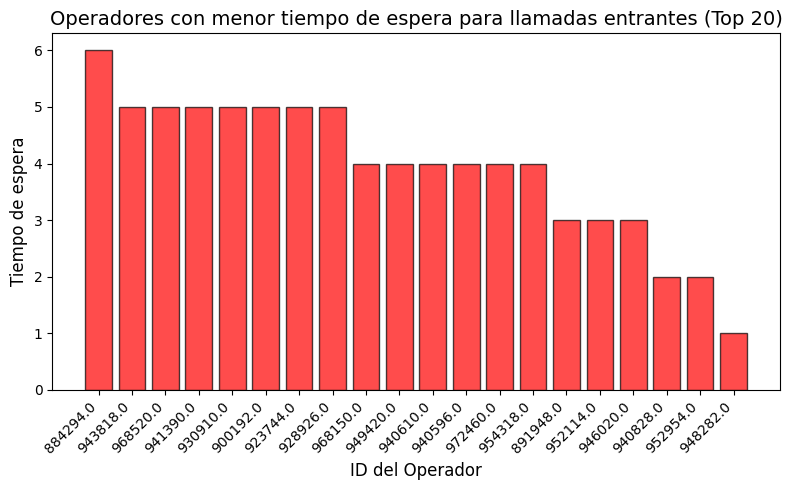

In [19]:
operators_less_waiting_times = operator_waiting_cleaned.tail(20)

labels = operators_less_waiting_times['operator_id'].astype(str).to_list()

y_values = operators_less_waiting_times['total_waiting_times']

plt.figure(figsize=(8, 5))
plt.bar(labels, y_values, color='red', edgecolor='black', alpha=0.7)

plt.xlabel('ID del Operador', fontsize=12)
plt.ylabel('Tiempo de espera', fontsize=12)
plt.title('Operadores con menor tiempo de espera para llamadas entrantes (Top 20)', fontsize=14)

plt.xticks(rotation=45, fontsize=10, ha='right')

plt.tight_layout()

plt.show()

En la gráfica anterior se muestran los 20 operadores con menores tiempos de espera, donde se observa datos muy parejos y el valor máximo de espera fue de 6 minutos, por lo que se les podría considerar parte de los operadores eficaces.

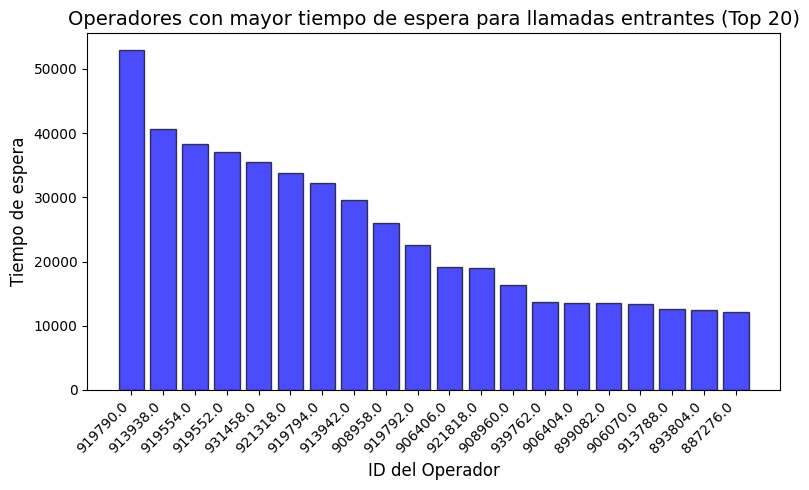

In [20]:
operator_waiting_cleaned_top20 = operator_waiting_cleaned.head(20)

labels = operator_waiting_cleaned_top20['operator_id'].astype(str).to_list()

y_values = operator_waiting_cleaned_top20['total_waiting_times']

plt.figure(figsize=(8, 5))
plt.bar(labels, y_values, color='blue', edgecolor='black', alpha=0.7)

plt.xlabel('ID del Operador', fontsize=12)
plt.ylabel('Tiempo de espera', fontsize=12)
plt.title('Operadores con mayor tiempo de espera para llamadas entrantes (Top 20)', fontsize=14)

plt.xticks(rotation=45, fontsize=10, ha='right')

plt.tight_layout()

plt.show()

En la gráfica anterior se muestran los 20 operadores con el mayor tiempo de espera proveniente de las llamadas entrantes, como se muestra, hay una amplia diferencia entre el primero y el último por más de 40000 minutos. 

In [21]:
operator_waiting_cleaned.describe()

,total_waiting_times
count,754.000000
mean,1635.656499
std,4637.607919
min,1.000000
25%,62.000000
50%,255.000000
75%,1064.250000
max,52875.000000


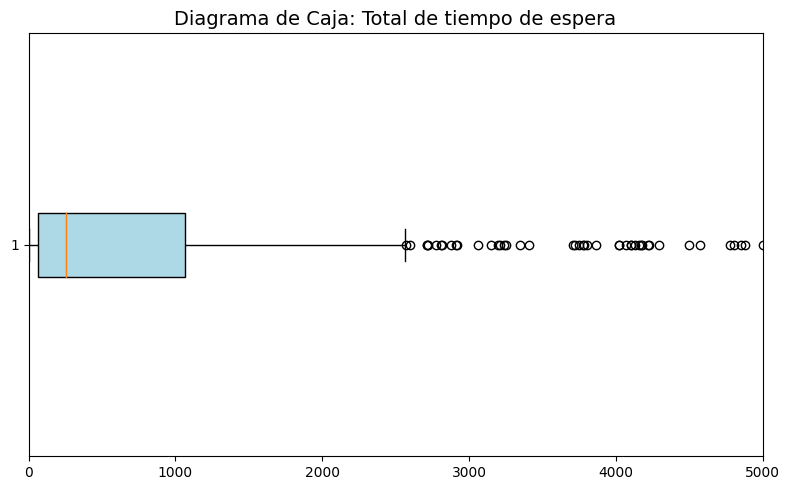

In [22]:
plt.figure(figsize=(8, 5))
plt.boxplot(operator_waiting_cleaned['total_waiting_times'], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))

plt.title('Diagrama de Caja: Total de tiempo de espera', fontsize=14)
plt.xlim(0, 5000)
plt.tight_layout()
plt.show()

El siguiente diagrama de caja nos ayuda a visualizar de una mejor manera la distribución de los datos, donde se observa claramente una proporción amplia de outliers, es decir, un 25% de los operadores tienen un tiempo de espera prolongado en comparación con el otro 75% por lo que es necesario encontrar el problema raíz, ya que con un porcentaje tan alto, es posible que no sea únicamente problema de los operadores. 

In [23]:
num_operators_time_waiting = operator_waiting_cleaned[operator_waiting_cleaned['total_waiting_times'] > 2800].shape[0]

print(f"Cantidad de operadores con más de 2800 minutos de espera: {num_operators_time_waiting}")

Cantidad de operadores con más de 2800 minutos de espera: 99


Se determinó que **a partir de los 2800 minutos de tiempo de espera para llamadas entrantes, se le considerará como un operador ineficaz** por lo que **se encontraron 99 operadores con más 2800 minutos** de espera de llamadas entrantes durante el lapso total del presente estudio.

In [24]:
operators_time_less_waiting = operator_waiting_cleaned[operator_waiting_cleaned['total_waiting_times'] < 62].shape[0]

print(f"Cantidad de operadores con menos de 62 minutos de espera: {operators_time_less_waiting}")

Cantidad de operadores con menos de 62 minutos de espera: 188


**Después de analizar el diagrama de caja, se determinó que los operadoes con menos de 62 de espera, se consideran eficaces.**

Creamos dos df para después realizar un merge con los operadores tanto eficaces como ineficaces: 

In [25]:
operators_less_time_waiting = operator_waiting_cleaned[operator_waiting_cleaned['total_waiting_times'] < 62]
operators_time_waiting = operator_waiting_cleaned[operator_waiting_cleaned['total_waiting_times'] > 2800]

### Llamadas perdidas. 
Se considera que un operador es ineficaz si tiene una gran cantidad de llamadas entrantes perdidas (internas y externas). Los operadores que con mayores cantidades de llamadas perdidas entraran en una lista para verificar si realmente con ineficaces. 

In [26]:
telecom_data['calls_internal_missed'] = telecom_data['is_missed_call'] * telecom_data['internal']

calls_missed = telecom_data.pivot_table(
    index='operator_id',
    values=['is_missed_call', 'calls_internal_missed'],
    aggfunc='sum'
).sort_values(by='is_missed_call', ascending=False)

calls_missed['calls_external_missed'] = calls_missed['is_missed_call'] - calls_missed['calls_internal_missed']

calls_missed = calls_missed.rename(columns={'is_missed_call': 'total_calls_missed'})

print(calls_missed.head(10))

             calls_internal_missed  total_calls_missed  calls_external_missed
operator_id                                                                  
Unknown                        310                7343                   7033
891410.0                        42                 119                     77
885876.0                         2                 115                    113
891414.0                        42                 113                     71
901880.0                        19                 111                     92
893804.0                        23                 110                     87
901884.0                        22                 104                     82
885890.0                         0                 101                    101
905538.0                        34                  93                     59
887276.0                        31                  91                     60


Anteriormente se le asigno el valor de 1 a las llamadas internas es decir, 1 = True. Por lo que para obtener las llamadas perdidas internas se multiplico la columna de las llamadas perdidas totales por la columna de las llamadas internas. Ya con esta columna, únicamente se realizo una resta de la columna de las llamadas perdidas totales menos la columna de las llamadas perdidas internas, para obtener la columna de llamadas externas perdidas. 

In [27]:
calls_missed_cleaned = calls_missed.iloc[1:]

calls_missed_cleaned.index = calls_missed_cleaned.index.astype(str)

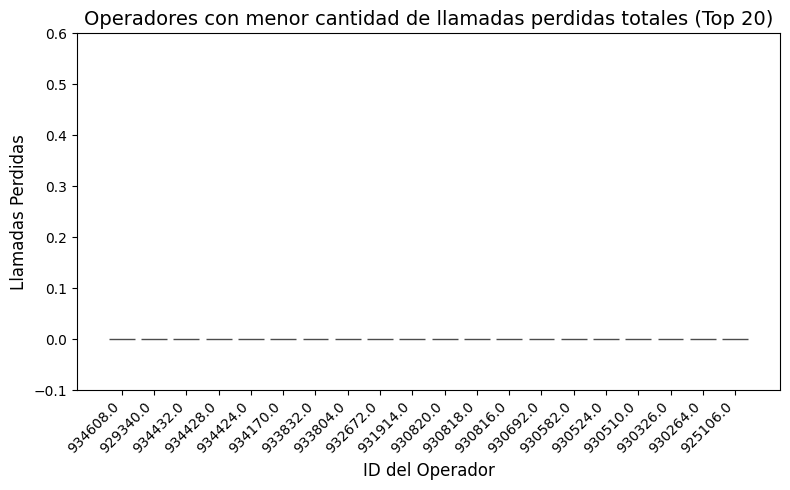

In [28]:
less_calls_missed_top_20 = calls_missed_cleaned.tail(20)

labels = less_calls_missed_top_20.index.to_list()
labels = [str(x) for x in labels]

y_values = less_calls_missed_top_20['total_calls_missed']

plt.figure(figsize=(8, 5))
plt.bar(labels, y_values, color='red', edgecolor='black', alpha=0.7)

plt.xlabel('ID del Operador', fontsize=12)
plt.ylabel('Llamadas Perdidas', fontsize=12)
plt.title('Operadores con menor cantidad de llamadas perdidas totales (Top 20)', fontsize=14)

plt.xticks(rotation=45, fontsize=10, ha='right')
plt.ylim(-0.1, 0.6)

plt.tight_layout()

plt.show()

Después de graficar lo anterior, podemos observar que existen por lo menos 20 operadores que no tienen llamadas perdidas tanto internas como externas a lo largo del estudio, por lo que se les podría considerar parte de los operadores eficaces.

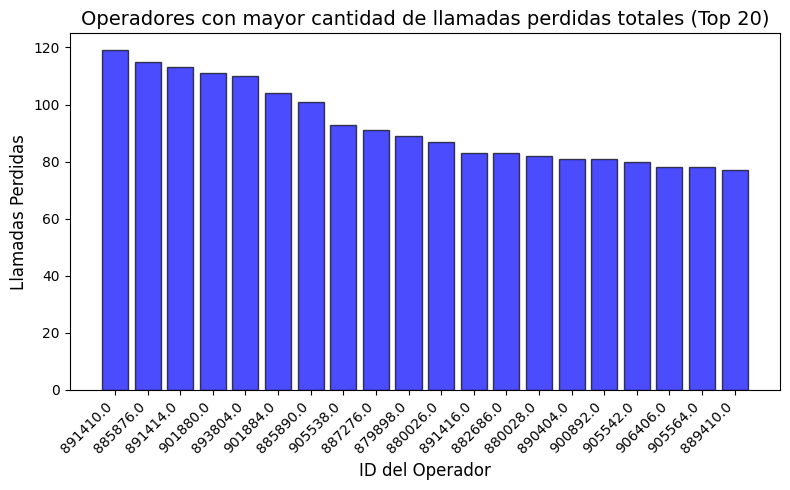

In [29]:
calls_missed_top_20 = calls_missed_cleaned.head(20)

labels = calls_missed_top_20.index.to_list()
labels = [str(x) for x in labels]

y_values = calls_missed_top_20['total_calls_missed']

plt.figure(figsize=(8, 5))
plt.bar(labels, y_values, color='blue', edgecolor='black', alpha=0.7)

plt.xlabel('ID del Operador', fontsize=12)
plt.ylabel('Llamadas Perdidas', fontsize=12)
plt.title('Operadores con mayor cantidad de llamadas perdidas totales (Top 20)', fontsize=14)

plt.xticks(rotation=45, fontsize=10, ha='right')

plt.tight_layout()

plt.show()

Se presentan los 20 operadores con mayor cantidad de llamadas perdidas, tanto internas como externas. 

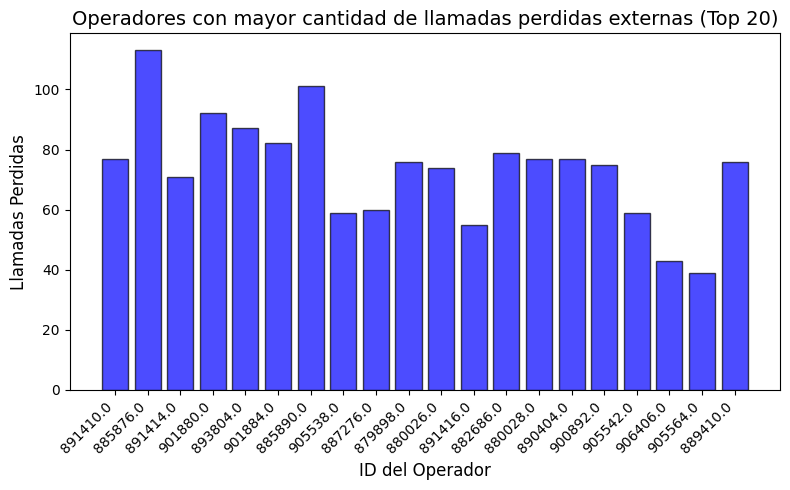

In [30]:
labels = calls_missed_top_20.index.to_list()
labels = [str(x) for x in labels]

y_values = calls_missed_top_20['calls_external_missed']

plt.figure(figsize=(8, 5))
plt.bar(labels, y_values, color='blue', edgecolor='black', alpha=0.7)

plt.xlabel('ID del Operador', fontsize=12)
plt.ylabel('Llamadas Perdidas', fontsize=12)
plt.title('Operadores con mayor cantidad de llamadas perdidas externas (Top 20)', fontsize=14)

plt.xticks(rotation=45, fontsize=10, ha='right')

plt.tight_layout()

plt.show()

La gráfica anterior, muestra la distribución de las llamadas perdidas externas de los 20 operadores con más llamadas perdidas totales.

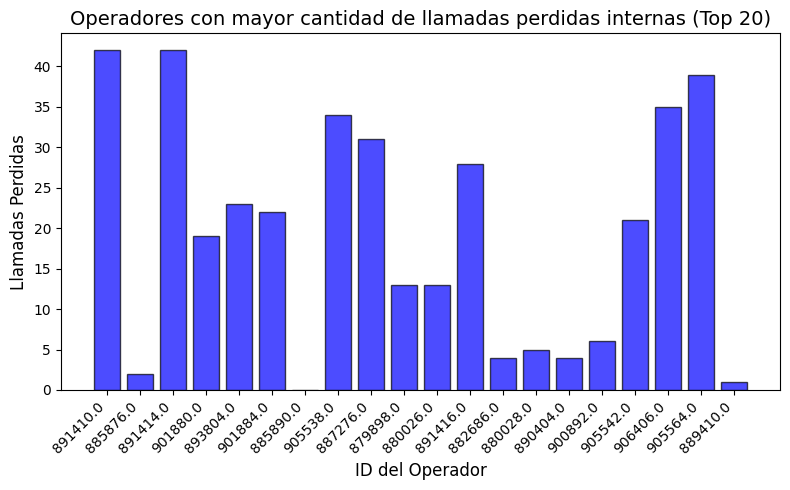

In [31]:
labels = calls_missed_top_20.index.to_list()
labels = [str(x) for x in labels]  # Asegurar que los índices sean cadenas

y_values = calls_missed_top_20['calls_internal_missed']

plt.figure(figsize=(8, 5))
plt.bar(labels, y_values, color='blue', edgecolor='black', alpha=0.7)

plt.xlabel('ID del Operador', fontsize=12)
plt.ylabel('Llamadas Perdidas', fontsize=12)
plt.title('Operadores con mayor cantidad de llamadas perdidas internas (Top 20)', fontsize=14)

plt.xticks(rotation=45, fontsize=10, ha='right')

plt.tight_layout()

plt.show()

La gráfica anterior, muestra la distribución de las llamadas perdidas internas de los 20 operadores con más llamadas perdidas totales.

In [32]:
calls_missed_cleaned.describe()

,calls_internal_missed,total_calls_missed,calls_external_missed
count,1092.000000,1092.000000,1092.000000
mean,2.208791,12.921245,10.712454
std,5.329337,18.394028,15.945936
min,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000
50%,0.000000,5.000000,4.000000
75%,2.000000,18.000000,15.000000
max,42.000000,119.000000,113.000000


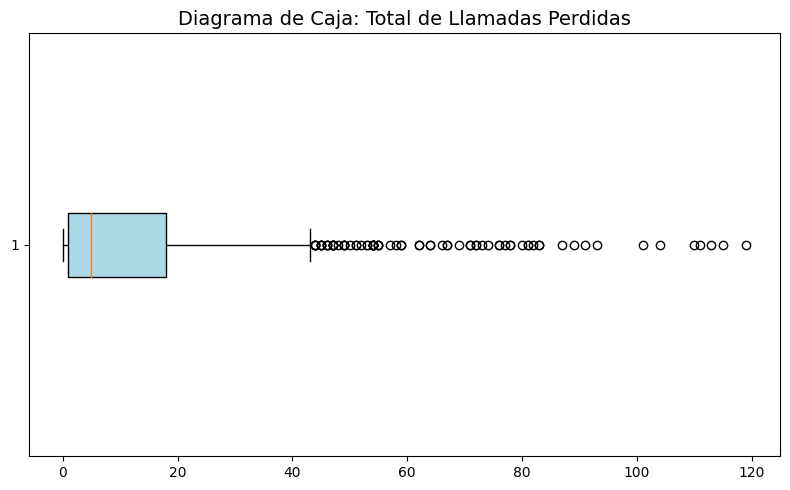

In [33]:
plt.figure(figsize=(8, 5))
plt.boxplot(calls_missed_cleaned['total_calls_missed'], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))

plt.title('Diagrama de Caja: Total de Llamadas Perdidas', fontsize=14)

plt.tight_layout()
plt.show()

In [34]:
operators_with_more_calls_missed = calls_missed_cleaned[calls_missed_cleaned['total_calls_missed'] > 43].shape[0]

print(f"Cantidad de operadores con más de 43 llamadas perdidas: {operators_with_more_calls_missed}")

Cantidad de operadores con más de 43 llamadas perdidas: 76


El diagrama de caja anterior representa las llamadas perdidas totales de cada operador, por lo que podemos deducir que durante el periodo que se realizó el estudio, **cualquier operador que tenga más de 43 llamadas perdidas totales, se le considerará un operador ineficaz**. Por lo que hay que poner atención en dichos operadores. En los histogramas anteriores se observa el comportamiento de los 20 operadores con más llamadas perdidas, entre internas y externas. Y por ultimo se calculó el número de operadores con más de 43 llamadas perdidas y **tenemos que hay 76 operadores considerados ineficaces.**

In [35]:
operators_with_less_calls_missed = calls_missed_cleaned[calls_missed_cleaned['total_calls_missed'] < 1].shape[0]

print(f"Cantidad de operadores con menos de 1 llamada pérdida: {operators_with_less_calls_missed}")

Cantidad de operadores con menos de 1 llamada pérdida: 216


**Después de analizar, se determinó que los operadores eficaces se consideran aquellos que tienen menos de una llamada perdida.**

Creamos dos df para después realizar un merge con los operadores tanto eficaces como ineficaces: 

In [36]:
operators_calls_missed = calls_missed_cleaned[calls_missed_cleaned['total_calls_missed'] > 43]
operators_calls_missed = operators_calls_missed.drop(columns={'calls_internal_missed', 'calls_external_missed'})

operators_less_calls_missed = calls_missed_cleaned[calls_missed_cleaned['total_calls_missed'] < 1]
operators_less_calls_missed = operators_less_calls_missed.drop(columns={'calls_internal_missed', 'calls_external_missed'})

### Llamadas salientes

In [37]:
outcoming_calls = telecom_data[telecom_data['direction'] == 0]

outcoming_calls_per_operator = outcoming_calls.groupby('operator_id')['calls_count'].sum()

outcoming_calls_per_operator = outcoming_calls_per_operator.rename('total_calls').sort_values().reset_index()

outcoming_calls_per_operator.head()

,operator_id,total_calls
0,969284.0,1
1,937956.0,1
2,914440.0,1
3,914626.0,1
4,937872.0,1


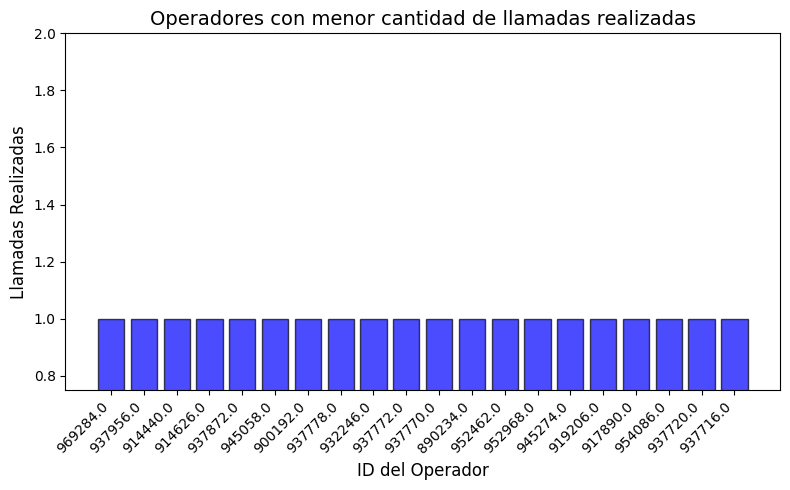

In [38]:
outcoming_calls_per_operator_less_calls = outcoming_calls_per_operator.head(20)

labels = outcoming_calls_per_operator_less_calls['operator_id'].astype(str).to_list()

y_values = outcoming_calls_per_operator_less_calls['total_calls']

plt.figure(figsize=(8, 5))
plt.bar(labels, y_values, color='blue', edgecolor='black', alpha=0.7)

plt.xlabel('ID del Operador', fontsize=12)
plt.ylabel('Llamadas Realizadas', fontsize=12)
plt.title('Operadores con menor cantidad de llamadas realizadas', fontsize=14)

plt.xticks(rotation=45, fontsize=10, ha='right')
plt.ylim(0.75, 2)

plt.tight_layout()

plt.show()

Después de revisar lo anterior podemos observar que hay mínimo 20 operadores que únicamente realizaron llamadas por lo que es necesario realizar un diagrama de caja para observar la distribución de los datos.

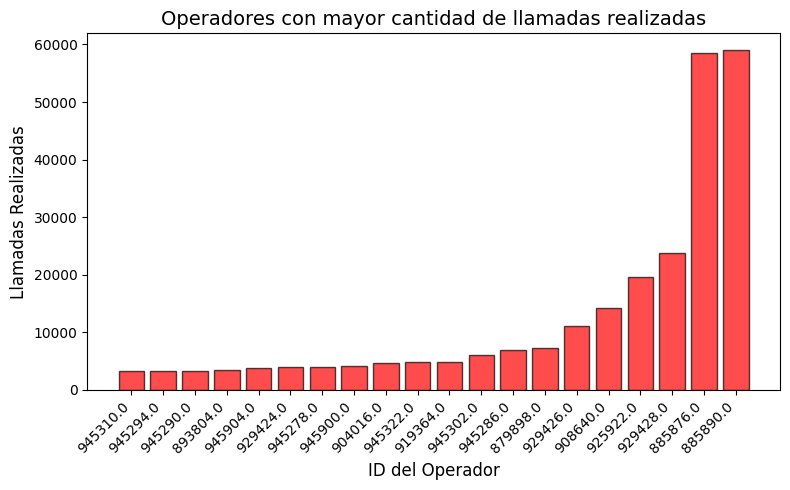

In [39]:
outcoming_calls_per_operator_more_calls = outcoming_calls_per_operator.tail(20)

labels = outcoming_calls_per_operator_more_calls['operator_id'].astype(str).to_list()

y_values = outcoming_calls_per_operator_more_calls['total_calls']

plt.figure(figsize=(8, 5))
plt.bar(labels, y_values, color='red', edgecolor='black', alpha=0.7)

plt.xlabel('ID del Operador', fontsize=12)
plt.ylabel('Llamadas Realizadas', fontsize=12)
plt.title('Operadores con mayor cantidad de llamadas realizadas', fontsize=14)

plt.xticks(rotation=45, fontsize=10, ha='right')

plt.tight_layout()

plt.show()

En la presente gráfica se muestran los operadores con más llamadas realizadas, donde se observa que los 6 operadorres con la mayor cantidad de llamadas superan las 10,000 llamadas, sin embargo, después de analizar esos valores no se consideran reales debido al tiempo del estudio, es necesario investigar que es lo que ocurre realmente con esos 6 operadores. 

In [40]:
outcoming_calls_per_operator_more_calls

,operator_id,total_calls
863,945310.0,3311
864,945294.0,3368
865,945290.0,3373
866,893804.0,3413
867,945904.0,3813
868,929424.0,3963
869,945278.0,4001
870,945900.0,4210
871,904016.0,4681
872,945322.0,4775


In [41]:
outcoming_calls_per_operator.shape

(883, 2)

In [42]:
outcoming_calls_per_operator.describe()

,total_calls
count,883.000000
mean,689.540204
std,3121.188227
min,1.000000
25%,11.000000
50%,90.000000
75%,591.500000
max,58977.000000


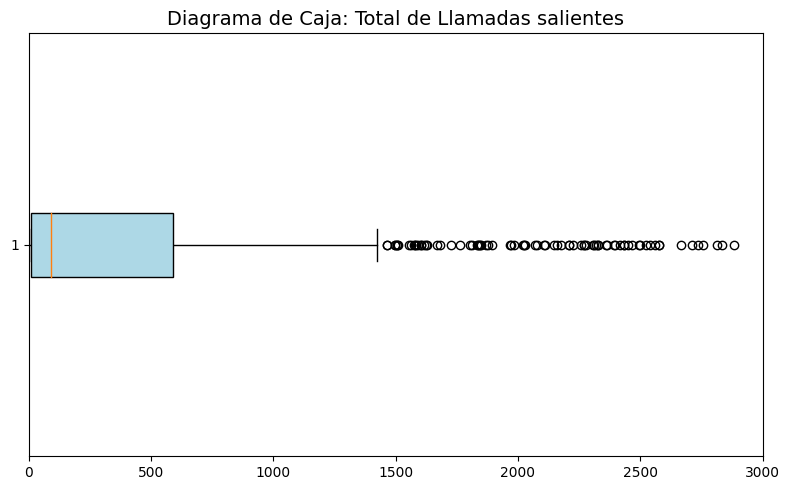

In [43]:
plt.figure(figsize=(8, 5))
plt.boxplot(outcoming_calls_per_operator['total_calls'], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))

plt.title('Diagrama de Caja: Total de Llamadas salientes', fontsize=14)

plt.xlim(0, 3000)
plt.tight_layout()
plt.show()

In [44]:
operators_with_fewer_outgoing_calls = outcoming_calls_per_operator[outcoming_calls_per_operator['total_calls'] < 11].shape[0]

print(f"Cantidad de operadores con menos de 11 llamadas salientes: {operators_with_fewer_outgoing_calls}")

Cantidad de operadores con menos de 11 llamadas salientes: 214


El diagrama de caja anterior representa las llamadas salientes totales de cada operador, por lo que podemos deducir que durante el periodo que se realizó el estudio, **cualquier operador que haya hecho menos de 11 llamadas salientes, se le considerará un operador ineficaz**. Por lo que hay que poner atención en dichos operadores. Se calculó el número de operadores con menos de 11 llamadas salientes y **tenemos que hay 214 operadores considerados ineficaces.**

In [45]:
operators_with_less_outgoing_calls = outcoming_calls_per_operator[outcoming_calls_per_operator['total_calls'] > 1500].shape[0]

print(f"Cantidad de operadores con más de 1500 llamadas salientes: {operators_with_less_outgoing_calls}")

Cantidad de operadores con más de 1500 llamadas salientes: 99


**Después de analizar el diagrama de caja, se determinó que los operadores eficaces se consideraban de 1500 llamadas salientes en adelante.**

Creamos dos DataFrames para después realizar un merge con los operadores tanto eficaces como ineficaces: 

In [46]:
operators_outgoing_calls = outcoming_calls_per_operator[outcoming_calls_per_operator['total_calls'] < 11]
operators_more_calls = outcoming_calls_per_operator[outcoming_calls_per_operator['total_calls'] > 1500]

### Operadores ineficaces y eficaces: 

Criterios para identificar un **operador ineficaz**: 
- Existe una gran cantidad de llamadas entrantes perdidas (internas y externas)
- Tiempo de espera prolongado para las llamadas entrantes
- Número reducido de llamadas salientes

In [47]:
inefficient_operators_0 = operators_outgoing_calls.merge(operators_time_waiting, on='operator_id', how='left')

inefficient_operators_1 = inefficient_operators_0.merge(operators_calls_missed, on='operator_id', how='left')

inefficient_operators_1 = inefficient_operators_1.reset_index(drop=True).sort_values(by='total_waiting_times')

inefficient_operators_1.head()

,operator_id,total_calls,total_waiting_times,total_calls_missed
206,919164.0,10,4023.0,NaN
135,909134.0,5,6939.0,NaN
15,919206.0,1,7373.0,NaN
185,919204.0,9,9366.0,NaN
0,969284.0,1,NaN,NaN


Combinando los operadores que cuentan con los tres criterios tenemos que únicamente hay 4 operadores que cuentan con 2 de los 3 criterios:
1. 919164.0
2. 909134.0
3. 919206.0
4. 969284.0

Estos cuatro operadores cuentan con 2 criterios, que son pocas llamadas realizadas y tiempos de espera prolongado y es necesario reportarlo con los supervisores, para que decidan que tipo de capacitación se les da. 

In [48]:
inefficient_operators_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214 entries, 206 to 213
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   operator_id          214 non-null    object 
 1   total_calls          214 non-null    int64  
 2   total_waiting_times  4 non-null      float64
 3   total_calls_missed   0 non-null      float64
dtypes: float64(2), int64(1), object(1)
memory usage: 8.4+ KB


In [49]:
total_number_of_inefficient_operators = operators_with_fewer_outgoing_calls + num_operators_time_waiting + operators_with_more_calls_missed - 4
print(f"OPERADORES CONSIDERADOS INEFICIENTES: {total_number_of_inefficient_operators}")

OPERADORES CONSIDERADOS INEFICIENTES: 385


In [50]:
total_number_of_operators = telecom_data['operator_id'].nunique()

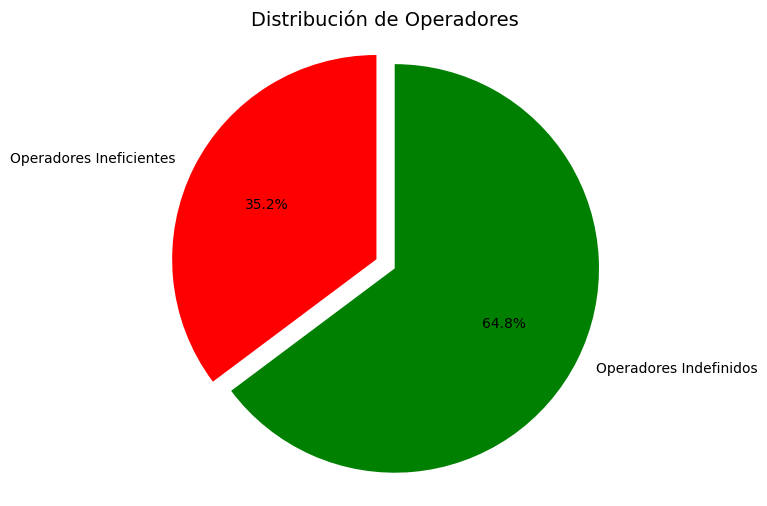

In [51]:
pending_evaluation = total_number_of_operators - total_number_of_inefficient_operators

labels = ['Operadores Ineficientes', 'Operadores Indefinidos']
sizes = [total_number_of_inefficient_operators, pending_evaluation]
colors = ['red', 'green']
explode = (0.1, 0)  

# Crear gráfica de pastel
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, explode=explode, startangle=90)
plt.title('Distribución de Operadores', fontsize=14)
plt.axis('equal')  # Asegura que el gráfico sea un círculo perfecto

plt.show()

En la gráfica anterios, se muestra la proporción de operadores considerados ineficaces, es preciso mencionar que a pesar de que un operador tuviera buenos numeros en otras areas, si cumple con alguno de los 3 criterios, se le consideró ineficaz. 

Criterios para identificar un **operador eficaz**: 
- Existe la menor cantidad de llamadas entrantes perdidas (internas y externas)
- Tiempo de espera mínimo para las llamadas entrantes
- Mejores numeros de llamadas salientes

In [52]:
efficient_operators = operators_less_calls_missed.merge(operators_more_calls, on='operator_id', how='left')

efficient_operators_1 = efficient_operators.merge(operators_less_time_waiting, on='operator_id', how='left')

efficient_operators_1 = efficient_operators_1.reset_index(drop=True)

efficient_operators_1.head(3)

,operator_id,total_calls_missed,total_calls,total_waiting_times
0,951118.0,0,NaN,NaN
1,969268.0,0,NaN,NaN
2,953952.0,0,NaN,NaN


In [53]:
efficient_operators_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   operator_id          216 non-null    object 
 1   total_calls_missed   216 non-null    int64  
 2   total_calls          0 non-null      float64
 3   total_waiting_times  0 non-null      float64
dtypes: float64(2), int64(1), object(1)
memory usage: 6.9+ KB


In [54]:
total_number_of_efficient_operators = operators_with_less_outgoing_calls + operators_with_less_calls_missed + operators_time_less_waiting
print(f"OPERADORES CONSIDERADOS EFICIENTES: {total_number_of_efficient_operators}")

OPERADORES CONSIDERADOS EFICIENTES: 503


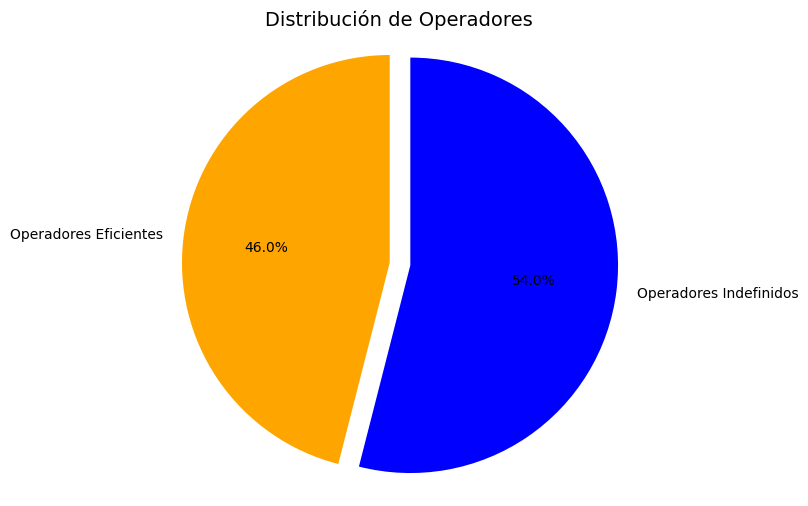

In [55]:
indefinite_operators = total_number_of_operators - total_number_of_efficient_operators

labels = ['Operadores Eficientes', 'Operadores Indefinidos']
sizes = [total_number_of_efficient_operators, indefinite_operators]
colors = ['orange', 'blue']
explode = (0.1, 0)  

# Crear gráfica de pastel
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, explode=explode, startangle=90)
plt.title('Distribución de Operadores', fontsize=14)
plt.axis('equal')

plt.show()

La gráfica anterior, muestra el porcentaje de operadores considerados eficaces, como podemos observar es un dato cercano al 50%, lo que indica que van por buen camino, sin embargo, hay que considerar que solo cumplen con un criterio y que en los demás son considerados como la media, por lo que hay seguir instruyendo en las áereas para también sean mejores en ellas. 


In [56]:
merge_comparativa = efficient_operators_1.merge(inefficient_operators_1, on='operator_id', how='left')
merge_comparativa.head(3)

,operator_id,total_calls_missed_x,total_calls_x,total_waiting_times_x,total_calls_y,total_waiting_times_y,total_calls_missed_y
0,951118.0,0,NaN,NaN,NaN,NaN,NaN
1,969268.0,0,NaN,NaN,NaN,NaN,NaN
2,953952.0,0,NaN,NaN,NaN,NaN,NaN


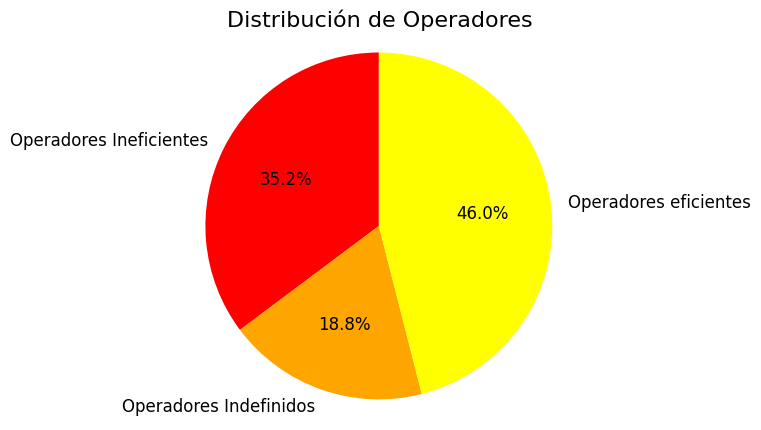

In [57]:
operators_no_class = total_number_of_operators - total_number_of_inefficient_operators - total_number_of_efficient_operators

labels = ['Operadores Ineficientes', 'Operadores Indefinidos', 'Operadores eficientes']
sizes = [total_number_of_inefficient_operators, operators_no_class, total_number_of_efficient_operators]
colors = ['red', 'orange', 'yellow']
 

# Crear la gráfica de pastel
plt.figure(figsize=(7, 5))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 12})
plt.title('Distribución de Operadores', fontsize=16)
plt.axis('equal')  # Asegura que el gráfico sea un círculo

# Mostrar la gráfica
plt.show()

En la gráfica anterior, se muestra el porcentaje combinado ya con los operadores eficaces, ineficientes, y los indedefinidos donde, claramente se observa que a pesar de que hay mayor cantidad de operadores eficaces, aun siguen siendo muchos operadores ineficaces por lo que hay que poner atención  

## Análisis de las llamadas

In [58]:
calls_per_day = telecom_data.groupby('day')['calls_count'].sum()
calls_per_day.tail()

day
2019-11-24     4099
2019-11-25    17502
2019-11-26    16542
2019-11-27    14790
2019-11-28    14535
Name: calls_count, dtype: int64

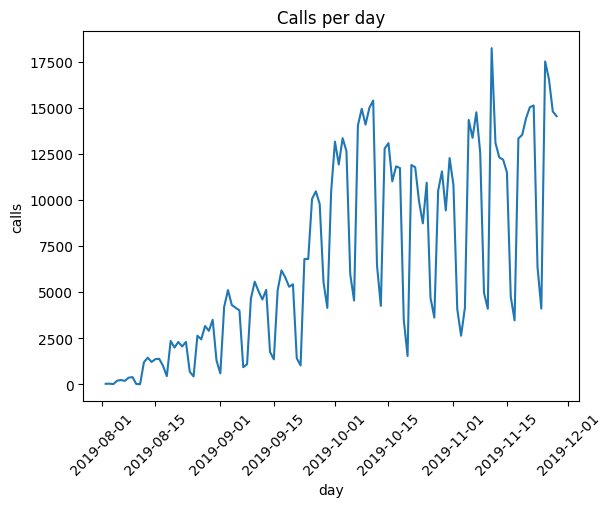

In [59]:
plt.plot(calls_per_day)
plt.xlabel('day')
plt.ylabel('calls')
plt.title("Calls per day")
plt.xticks(rotation=45)
plt.show()

La siguiente gráfica es interesante porque podemos observar el comportamiento de las llamadas tanto entrantes, como salientes, es preciso mencionar que los días en que baja la cantidad de llamadas son los domingos, y a pesar que disminuye el volumen de las llamadas, los operadores siguen laborando, es necesario mencionarlo para que no haya confusiones al momento de analizar los datos. 

In [60]:
calls_per_day.describe()

count      119.000000
mean      6779.067227
std       5252.253818
min          2.000000
25%       2170.000000
50%       5096.000000
75%      11851.500000
max      18222.000000
Name: calls_count, dtype: float64

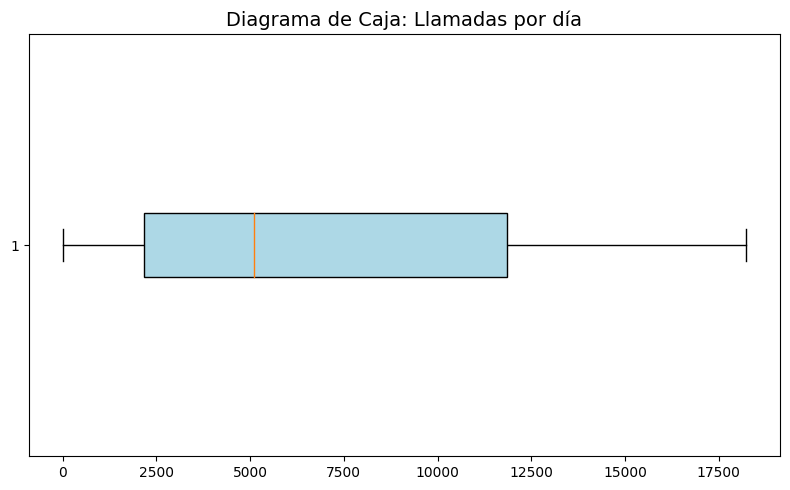

In [61]:
plt.figure(figsize=(8, 5))
plt.boxplot(calls_per_day, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))

plt.title('Diagrama de Caja: Llamadas por día', fontsize=14)

plt.tight_layout()
plt.show()

Como se muestra en el diagrama de caja los datos son simetricos y no tenemos outliers

In [62]:
calls_per_month = telecom_data.groupby('month')['calls_count'].sum()
calls_per_month.head()

month
2019-08-01     37391
2019-09-01    146590
2019-10-01    316299
2019-11-01    306429
Name: calls_count, dtype: int64

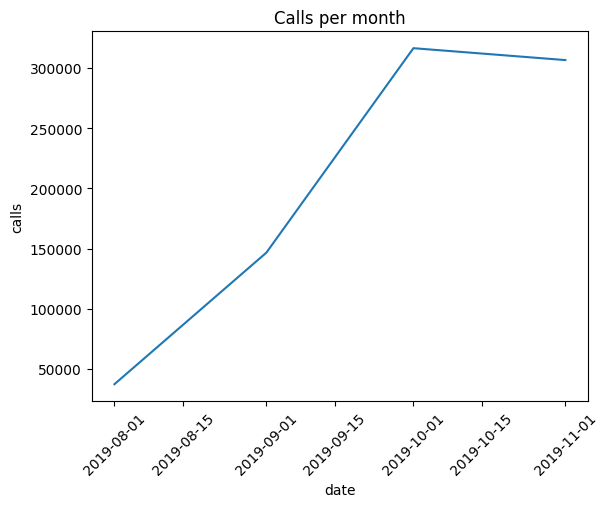

In [63]:
plt.plot(calls_per_month)
plt.xlabel('date')
plt.ylabel('calls')
plt.title("Calls per month")
plt.xticks(rotation=45)
plt.show()

Es preciso mencionar que a comparación con la gráfica de llamadas por día, aqui se logra observar como han ido incrementando las llamadas de manera exponencial, lo que puede llegar a explicar el comportamiento de algunos operadores, sobretodo los de menos experiencia, donde al principio puede que estuvieran más comodos pero con el paso del tiempo fue incrementando el trabajo, además se ve a partir del mes de octubre ya las llamadas empiezan a estabilizarse. 

In [64]:
telecom_clients.head()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


In [65]:
telecom_complete = telecom_data.merge(telecom_clients, on='user_id') 
telecom_complete.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,day,month,waiting_time,calls_internal_missed,tariff_plan,date_start
0,166377,2019-08-04 00:00:00+03:00,1,0,Unknown,1,2,0,4,2019-08-04,2019-08-01,4,0,B,2019-08-01
1,166377,2019-08-05 00:00:00+03:00,0,1,880022.0,1,3,0,5,2019-08-05,2019-08-01,5,1,B,2019-08-01
2,166377,2019-08-05 00:00:00+03:00,0,1,880020.0,1,1,0,1,2019-08-05,2019-08-01,1,1,B,2019-08-01
3,166377,2019-08-05 00:00:00+03:00,0,1,880020.0,0,1,10,18,2019-08-05,2019-08-01,8,0,B,2019-08-01
4,166377,2019-08-05 00:00:00+03:00,0,0,880022.0,1,3,0,25,2019-08-05,2019-08-01,25,0,B,2019-08-01


Llamadas internas y externas [43349, 5653]


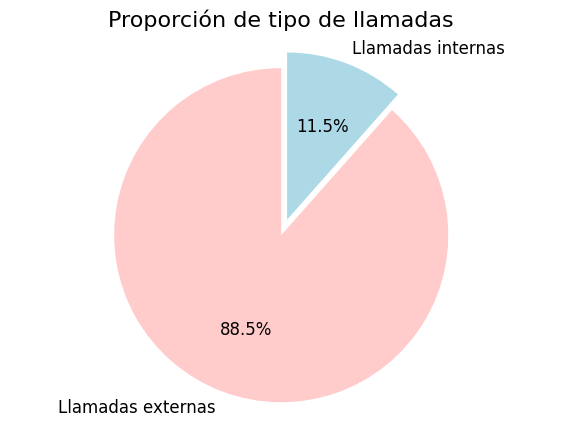

In [66]:
labels = ['Llamadas externas', 'Llamadas internas']
sizes = telecom_complete['internal'].value_counts(sort=False).tolist()
colors = ['#ffcccb', '#add8e6']
explode = (0, 0.1)

print(f'Llamadas internas y externas', sizes)

plt.figure(figsize=(7, 5))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 12})
plt.title('Proporción de tipo de llamadas', fontsize=16)
plt.axis('equal')  # Asegura que el gráfico sea un círculo

plt.show()

En la presente gráfica, se muestra la proporción de las llamas donde se observa claramente una amplia difrencia de las llamadas externas, es decir, por lo que se puede deducir que no hay muchas llamadas entre operadores.  

In [67]:
telecom_complete['direction'].sum()

20003

Proporción de la dirección de llamadas (salientes y entrantes) [28999, 20003]


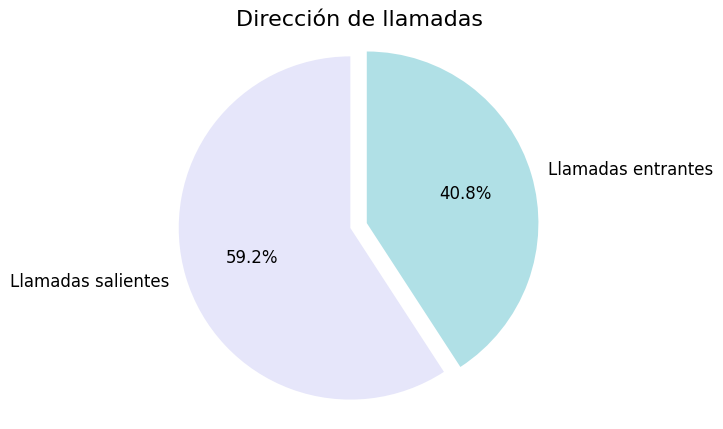

In [68]:
labels = ['Llamadas salientes', 'Llamadas entrantes']
sizes = telecom_complete['direction'].value_counts(sort=False).tolist()
colors = ['#e6e6fa', '#b0e0e6']
explode = (0, 0.1)

print(f'Proporción de la dirección de llamadas (salientes y entrantes)', sizes)

plt.figure(figsize=(7, 5))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 12})
plt.title('Dirección de llamadas', fontsize=16)
plt.axis('equal')  # Asegura que el gráfico sea un círculo

plt.show()

Es interesante ver la proporción de este dato ya que de esta manera, el valor que tiene el criterio de los operadores que tienen mayores llamadas salientes tiene más peso sobre los que tienen menores tiempo de espera. 

## Prueba de hipótesis

Hipótesis 1 : No existe una relación significativa entre la duración total de una llamada y el tiempo de espera de un cliente. El aumento en la duración de una llamada no está asociado con un aumento o disminución en el tiempo de espera de un cliente

H₀: No existe una relación significativa entre la duración total de las llamadas y el tiempo de espera. Es decir, el hecho de que una llamada dure más o menos no influye en el tiempo que un cliente pasa esperando para ser atendido.

H₁: Existe una relación significativa entre la duración total de las llamadas y el tiempo de espera

In [69]:
# Calcular el coeficiente de correlación de Pearson y el valor p
corr, p_value = pearsonr(telecom_complete['total_call_duration'], telecom_complete['waiting_time'])

print("Coeficiente de correlación:", corr)
print("Valor p:", p_value)

if p_value < 0.05:
    print("Existe una correlación significativa entre la duración de la llamada y el tiempo de espera.")
else:
    print("No se encontró una correlación significativa.")

Coeficiente de correlación: 0.6788982547801299
Valor p: 0.0
Existe una correlación significativa entre la duración de la llamada y el tiempo de espera.


Hipótesis 2 : El aumento en el volumen de llamadas genera un incremento en los tiempos de espera. La correlación positiva entre calls_count y waiting_time indica que a medida que aumenta el número de llamadas, el sistema puede saturarse y los tiempos de espera se alargan.

H₀: No existe una relación entre el número de llamadas y el tiempo de espera.

H₁: A mayor número de llamadas, mayor tiempo de espera.

In [70]:
# Calcular el coeficiente de correlación de Pearson y el valor p
corr, p_value = pearsonr(telecom_complete['calls_count'], telecom_complete['waiting_time'])

# Imprimir los resultados
print("Coeficiente de correlación:", corr)
print("Valor p:", p_value)

# Si p_value < 0.05, se rechaza la hipótesis nula
if p_value < 0.05:
    print("Existe una correlación significativa entre el número de llamadas y el tiempo de espera.")
else:
    print("No se encontró una correlación significativa.")

Coeficiente de correlación: 0.7893012892639848
Valor p: 0.0
Existe una correlación significativa entre el número de llamadas y el tiempo de espera.


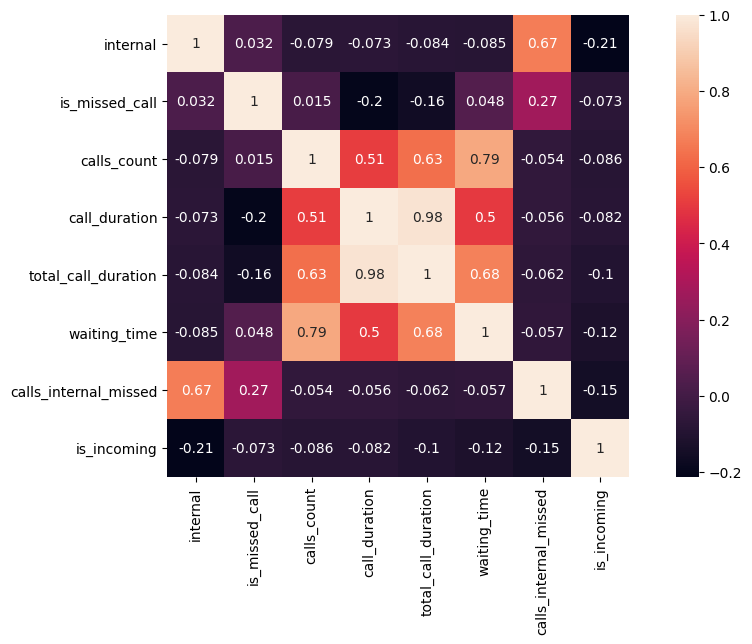

In [71]:
telecom_data['is_incoming'] = (telecom_data['direction'] == 1).astype(int)

df= telecom_data.drop(['direction','user_id','operator_id'], axis=1)
df_corr = df.corr()

plt.figure(figsize=(12, 6))
sns.heatmap(df_corr, annot=True, square=True)
plt.show()

Correlación positiva muy fuerte:

Las columnas: call_duration y total_call_duration,  están muy fuertemente correlacionadas entre sí. Esto es lógico, ya que a mayor número de llamadas, mayor será la duración total de las llamadas y viceversa.

Correlación positiva fuerte:

calls_count tiene una correlación positiva fuerte con waiting_time. Esto podría indicar que a medida que aumenta el número de llamadas, también aumenta el tiempo de espera en promedio.

total_call_duration tiene una correlación positiva fuerte con waiting_time. Esto sugiere que la duracion de las llamadas, tienden a tener tiempos de espera más largos.

## Conclusiones


Tras el análisis de los resultados, se concluye que no es imprescindible que un operador cumpla con los tres criterios previamente establecidos para ser considerado ineficaz. Es fundamental evaluar cada criterio de manera individual y, con base en los resultados, enfocar la capacitación en las áreas específicas donde se identifiquen oportunidades de mejora.

Sin embargo, al combinar los tres criterios, se identificaron cuatro operadores que cumplen con dos de ellos: 919164.0, 909134.0, 919206.0 y 919204.0. La lista de estos operadores, junto con los datos específicos de cada criterio en los que fueron clasificados como ineficaces, será enviada a los supervisores, quienes decidirán las acciones a implementar en cada caso.


## Recomendaciones

**Gestión del Volumen de Llamadas:**

- Implementación de un sistema de cola virtual: Reducir el tiempo de espera de los clientes al permitirles dejar un mensaje y ser contactados más tarde.
- Ofrecer opciones de autoservicio automatizado: Implementar un sistema de autoservicio para que los clientes puedan encontrar respuestas a sus preguntas más comunes sin necesidad de hablar con un operador. 
- Separar a operadores que únicamente se dediquen a realizar llamadas y otro grupo de operadores que solamente se dediquen a recibir llamadas, de esta manera tendremos un panorama de los operadores ya que con tantas variables es posible que así como algunos tengan más capacidad de recibir o de contestar llamadas. 

Optimización de Procesos:
Simplificación de flujos de trabajo: Revisar y optimizar los procesos existentes para eliminar pasos innecesarios y agilizar la atención a los clientes.

Implementación de herramientas tecnológicas: Utilizar herramientas como CRM, sistemas de gestión de llamadas y chatbots para automatizar tareas y mejorar la eficiencia.

Establecimiento de métricas claras: Definir indicadores clave de desempeño (KPI) para medir la eficiencia de los operadores y establecer objetivos claros.

Otras variables a considerar:
Complejidad de las llamadas: Las llamadas que requieren una mayor atención o conocimientos especializados pueden aumentar el tiempo de resolución.

Disponibilidad de información: La falta de acceso a la información necesaria puede prolongar el tiempo de resolución de las llamadas.

Capacitación del operador: Un operador con menor experiencia o capacitación puede tardar más en resolver un problema. Al analizar estos factores en conjunto, se puede obtener una comprensión más completa de los factores que influyen en el tiempo de espera y tomar decisiones más informadas para mejorar la eficiencia de los operadores y la satisfacción del cliente.